In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io.extxyz import read_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.formats import index2range
from ase.io.cfg import read_cfg
from io import StringIO, UnsupportedOperation
from mtp import *
import os
from matplotlib import pyplot as plt
from quippy.potential import Potential
import pickle
from Ge_analysis import *
from Ge_calculation import *
import matplotlib.pyplot as plt
from matscipy.rings import ring_statistics
from datetime import datetime
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal
from ase.io.extxyz import write_xyz
from ase.io.lammpsdata import write_lammps_data
from ase.io.castep import read_cell, write_cell
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io.castep import read_seed
from os.path import join
from ase.optimize import BFGSLineSearch
from re import findall

In [80]:
from calc_utils import *

In [3]:
mpl.style.use('VLD')

## Getting AIRSS up and running for building cells

In [4]:
os.chdir('/u/vld/hert5155/jup_remote/Ge_od/rss/Si_solid8')

In [5]:
pot = MTP('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/MTPs/u24_m1.5_fw0.1_PQ_rand_retrain_fromGAP18db.mtp',
         potential_name='u24_fw0.1_rand', mtp_command='/home/tridymite/vld/hert5155/mlip-2/bin/mlp', parallel=False)

In [151]:
u16_rand = MTP('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/MTPs/u16_m1.5_fw0.1_PQ1k_G18_scratch.mtp',
              potential_name='u16_fw0.1_rand', mtp_command='/home/tridymite/vld/hert5155/mlip-2/bin/mlp', parallel=False)

In [5]:
GAP_18_dir = '/u/vld/hert5155/jup_remote/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'
g18 = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')
g18.name = 'GAP-18'

/u/vld/hert5155/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


In [241]:
g18_lv = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml',
                  calc_args='local_gap_variance')

RuntimeError: Traceback (most recent call last)
  File "/u/vld/hert5155/QUIP/src/libAtoms/System.f95", line 520 kind unspecified
    IO error opening "gp_iter6_sparse9k.xml" on unit 8, error number: 5004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [244]:
g18_lv.calculate(dia_ref, args_str='local_gap_variance')

In [246]:
g18_lv.extra_results

{'config': {},
 'atoms': {'local_gap_variance': array([1.04081829e-06, 1.04081825e-06, 1.04081825e-06, 1.04081830e-06,
         1.04081829e-06, 1.04081827e-06, 1.04081832e-06, 1.04081828e-06]),
  'gap_variance_gradient': array([[-5.16519964e-13, -5.12242568e-13,  2.51596728e-13],
         [ 5.37462482e-13,  5.02743956e-13, -2.64674252e-13],
         [-5.18705772e-13, -5.16414940e-13,  2.83877486e-13],
         [ 5.33777645e-13,  5.19409003e-13, -2.67716572e-13],
         [-5.07532885e-13, -5.09974497e-13,  2.89811314e-13],
         [ 4.91786624e-13,  5.08617786e-13, -2.71950940e-13],
         [-5.11660883e-13, -5.15608734e-13,  2.50431905e-13],
         [ 4.92352668e-13,  5.24155823e-13, -2.70460160e-13]])}}

In [24]:
c = read_cell('Si_1.cell')
pot.calculate(c)

In [135]:
def opt(at, pot, P, fmax=5e-2, traj='tmp.traj', silent=False, name='NA', steps=100):
    '''Arguments
    init_structs: list of initial geometries for optimisation (must be close enough)
    pot: calculator object with which to perform opt
    P: pressure / eVA^-3'''

    at = at.copy()
    
    at.set_calculator(pot)
    #at.set_constraint(FixAtoms(mask=[True for atom in at]))
    uf = ExpCellFilter(at, scalar_pressure=P, hydrostatic_strain=True) # should ensure only the lattice can move, not atomic positions
    if silent:
        opt = BFGSLineSearch(atoms=uf, trajectory=traj, logfile='/dev/null')
    else:
        opt = BFGSLineSearch(atoms=uf, trajectory=traj)
                       
    opt.run(fmax, steps=steps) # converge to 0.1 GPa

    if not opt.converged():
        warnings.warn(('Warning: failed to converge on structure{}\n' +\
                      'in {} steps').format(Na, steps))
        #at.set_cell(np.NaN*np.ones(3)) # flag unconverged geometry

    at.set_calculator(None)

    return at, opt

In [39]:
cn = opt(c, g18, 0, silent=True)

In [40]:
traj = Trajectory('tmp.traj')

In [41]:
view(traj, viewer='ngl')

In [43]:
cells = [read_cell(i) for i in os.listdir() if 'Si_' in i]

In [49]:
opts = []; g18_e = []; mtp_e = []; mtp_f = []; g18_f = []
for ct, i in enumerate(cells):
    opts.append(opt(i, g18, 0, traj='{}.traj'.format(ct), silent=True))
    
    opts[-1].calc = g18
    g18_e.append(opts[-1].get_potential_energy())
    g18_f.append(opts[-1].get_forces())
    
    opts[-1].calc = pot
    mtp_e.append(opts[-1].get_potential_energy())
    mtp_f.append(opts[-1].get_forces())
    

<ipython-input-38-9bc962ca00a5>:20: UserWarning: Warning: failed to converge on structure
in 100 steps
  warnings.warn(('Warning: failed to converge on structure\n' +\


In [87]:
g18_e = np.array(g18_e); mtp_e = np.array(mtp_e)

In [72]:
with open('Si_g18opt_castep.pickle', 'rb') as f:
    cas = pickle.load(f)

In [85]:
cas_e = np.array([i.info['dft_energy'] for i in cas])
cas_f = np.array([i.arrays['dft_force'] for i in cas])

In [82]:
dia_ref = read_seed('dia_ref/dia_geom_1')
cas_e_ref = dia_ref.get_potential_energy()
dia_ref.calc = g18
g18_e_ref = dia_ref.get_potential_energy()
dia_ref.calc = pot
mtp_e_ref = dia_ref.get_potential_energy()

In [57]:
for i, val in enumerate(opts):
    with open('Si_g18opt_{}.cell'.format(i+1), 'w') as f:
        write_cell(f, val)

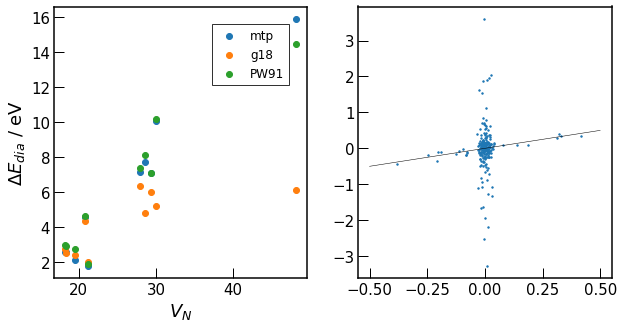

In [92]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = [i.get_volume()/len(i) for i in opts]
axs.scatter(v, mtp_e - mtp_e_ref, label='mtp')
axs.scatter(v, g18_e - g18_e_ref, label='g18')
axs.scatter(v, cas_e - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(g18_f).ravel(), np.array(mtp_f).ravel(), s=2)
axs2.plot(x:=np.linspace(-0.5,0.5), x, linewidth=0.5, color='k')

## More formalised

In [117]:
c_dir = 'build_test3'
cs = [read_cell(join(c_dir, i)) for i in os.listdir(c_dir) if 'Si_' in i]

In [118]:
uo_g18_e2 = []; uo_mtp_e2 = []; uo_g18_f2 = []; uo_mtp_f2 = []; 
for ct, i in enumerate(cs):
    
    i.calc = g18
    uo_g18_e2.append(i.get_potential_energy())
    uo_g18_f2.append(i.get_forces())
    
    i.calc = pot
    uo_mtp_e2.append(i.get_potential_energy())
    uo_mtp_f2.append(i.get_forces())

uo_g18_e2 = np.array(uo_g18_e2); uo_mtp_e2 = np.array(uo_mtp_e2)
uo_g18_f2 = np.array(uo_g18_f2); uo_mtp_f2 = np.array(uo_mtp_f2)

In [136]:
opts_2 = []; g18_e2 = []; mtp_e2 = []; mtp_f2 = []; g18_f2 = []; failed = []
for ct, i in enumerate(cs):
    
    at, n_opt = opt(i, g18, 0, traj='{}.traj'.format(ct), silent=True, name=ct)
    
    at.calc = g18
    if not n_opt.converged():
        failed.append(ct)
    at.calc = None
    
    opts_2.append(at)
    
    opts_2[-1].calc = g18
    g18_e2.append(opts_2[-1].get_potential_energy())
    g18_f2.append(opts_2[-1].get_forces())
    
    opts_2[-1].calc = pot
    mtp_e2.append(opts_2[-1].get_potential_energy())
    mtp_f2.append(opts_2[-1].get_forces())
g18_e2 = np.array(g18_e2); mtp_e2 = np.array(mtp_e2)

In [156]:
dia_ref.calc = u16_rand
u16_rand_e_ref = dia_ref.get_potential_energy()

In [155]:
u16_rand_e2 = []; u16_rand_f2 = []
for ct, i in enumerate(opts_2):
    at = i.copy()
    at.calc = u16_rand
    u16_rand_e2.append(at.get_potential_energy())
    u16_rand_f2.append(at.get_forces())
    at.calc = None

In [159]:
u16_rand_e2 = np.array(u16_rand_e2); u16_rand_f2 = np.array(u16_rand_f2)

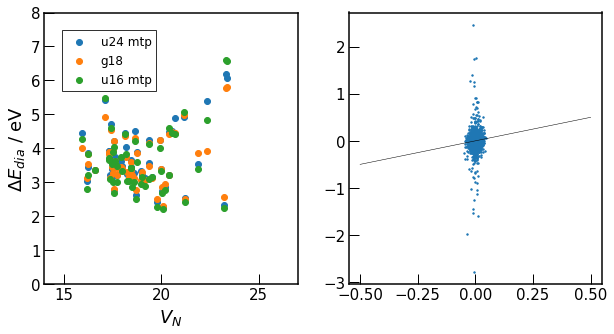

In [162]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = np.array([i.get_volume()/len(i) for i in opts_2])
axs.scatter(v, mtp_e2 - mtp_e_ref, label='u24 mtp')
axs.scatter(v, g18_e2 - g18_e_ref, label='g18')
axs.scatter(v, u16_rand_e2 - u16_rand_e_ref, label='u16 mtp')
axs.set(xlim=(14,27), ylim=(0,8))
# axs.scatter(v, cas_e2 - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(g18_f2).ravel(), np.array(mtp_f2).ravel(), s=2)
axs2.plot(x:=np.linspace(-0.5,0.5), x, linewidth=0.5, color='k')

In [167]:
rms_dict(g18_e2[np.where(v<27)], mtp_e2[np.where(v<27)]), rms_dict(g18_e2, mtp_e2)

({'rmse': 0.2865275677257074, 'std': 0.31550703698018123},
 {'rmse': 1.344728110994009, 'std': 11.063602049462817})

In [169]:
rms_dict(g18_e2[np.where(v<27)], u16_rand_e2[np.where(v<27)]), rms_dict(g18_e2, u16_rand_e2) 

({'rmse': 0.2924451208651083, 'std': 0.21864157103785237},
 {'rmse': 1.3729448855845934, 'std': 11.35978975958231})

In [119]:
rms_dict(uo_g18_e2, uo_mtp_e2)

{'rmse': 3.1364042022969696, 'std': 19.113838378560715}

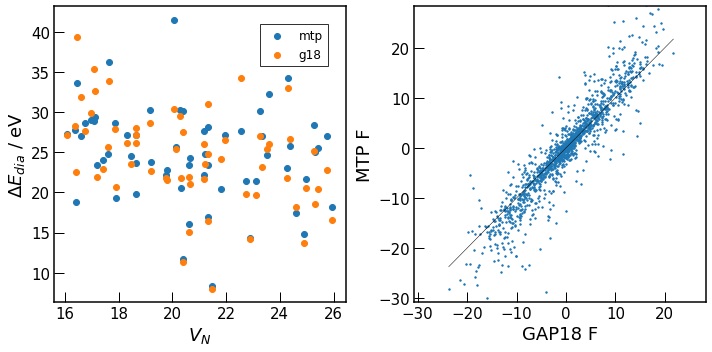

In [127]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = [i.get_volume()/len(i) for i in cs]
axs.scatter(v, uo_mtp_e2 - mtp_e_ref, label='mtp')
axs.scatter(v, uo_g18_e2 - g18_e_ref, label='g18')
# axs.scatter(v, uo_cas_e2 - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(uo_g18_f2).ravel(), np.array(uo_mtp_f2).ravel(), s=2)
axs2.plot(x:=np.linspace(mi:=uo_g18_f2.min(),ma:=uo_g18_f2.max()), x, linewidth=0.5, color='k')
axs2.set(xlabel=('GAP18 F'), ylabel='MTP F', xlim=(mi*1.3,ma*1.3), ylim=(mi*1.3,ma*1.3))
fig.tight_layout()

In [756]:
def gap_rss(cell_dir, opt_pot, eval_pot, ref_at):
    '''
    Retuns: uo_opt, uo_eval, o_opt, o_eval, refs, opts, cs
    '''
    
    
    cs = sorted([join(cell_dir, i) for i in os.listdir(cell_dir) if 'Si_' in i],
                key=lambda f: int(findall('\d+', f)[-1]))
    
    cs = [read_cell(i) for i in cs]
    
    ######### Reference calculation ###################
    ref_at.calc = opt_pot
    refs = [ref_at.get_potential_energy()]
    
    ref_at.calc = eval_pot
    refs.append(ref_at.get_potential_energy())

    ref_at.calc = None            
    ######### Evaluate unoptimised geometries ##########
                
    uo_opt = [[], [], [], []]; uo_eval = [[], [], [], []]; 

    for ct, i in enumerate(cs):

        i.calc = opt_pot
        uo_opt[0].append(i.get_potential_energy())
        uo_opt[1].append(i.get_forces())
        uo_opt[2].append(i.get_stress())
        if 'energies' in opt_pot.implemented_properties:
            uo_opt[3].append(i.get_potential_energies())
                

        i.calc = eval_pot
        uo_eval[0].append(i.get_potential_energy())
        uo_eval[1].append(i.get_forces())
        uo_eval[2].append(i.get_stress())
        if 'energies' in opt_pot.implemented_properties:
            uo_eval[3].append(i.get_potential_energies())

    uo_opt = [np.array(i) for i in uo_opt]
    uo_eval = [np.array(i) for i in uo_eval]
    i.calc = None
    
    #### Optimised geometries #########################
                
    pts = []; failed = []; opts = []
    o_opt = [[], [], [], []]; o_eval = [[], [], [], []];
    
    for ct, i in enumerate(cs):

        at, n_opt = opt(i, opt_pot, 0,
                        traj=join(cell_dir, '{}_{}.traj'.format(opt_pot.name, ct)),
                        silent=True, name=ct)

        at.calc = opt_pot
        if not n_opt.converged():
            failed.append(ct)
        at.calc = None

        opts.append(at)
        at.calc = opt_pot
        o_opt[0].append(at.get_potential_energy())
        o_opt[1].append(at.get_forces())
        o_opt[2].append(at.get_stress())
        if 'energies' in opt_pot.implemented_properties:
            o_opt[3].append(at.get_potential_energies())
                

        at.calc = eval_pot
        o_eval[0].append(at.get_potential_energy())
        o_eval[1].append(at.get_forces())
        o_eval[2].append(at.get_stress())
        if 'energies' in eval_pot.implemented_properties:
            o_eval[3].append(at.get_potential_energies())
        
        at.calc = None
        
    o_opt = [np.array(i) for i in o_opt]
    o_eval = [np.array(i) for i in o_eval]
    
    return [uo_opt, uo_eval, o_opt, o_eval, refs, opts, cs]

In [705]:
g18.implemented_properties

['energy', 'free_energy', 'forces', 'stress', 'stresses', 'energies']

In [193]:
g18,pot.name

(<quippy.potential.Potential at 0x7f092f14a9a0>, 'u24_fw0.1_rand')

In [194]:
sym_out = gap_rss('build_test_sym', g18, pot, dia_ref)

In [177]:
MTP_dir = '/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs_rmse/'
os.listdir(MTP_dir)

['MP_g18_u16_fw0.1.mtp',
 'g18_u16.mtp',
 'g18_u16_direct.mtp',
 'g18_u16_fw0.1.mtp',
 'g18_u16_fw0.1_direct.mtp',
 'g18_u20_fw0.1.mtp',
 'g18_u20_fw0.1_direct.mtp',
 'g18_u24_fw0.1.mtp',
 'g18_u24_fw0.1_direct.mtp',
 'PQ1k-1-5_g18_amo_u16_fw0.1.mtp',
 'PQ1k-1_g18_amo_u16_fw0.1.mtp',
 'PQ10k_g18_amo_u16_fw0.1.mtp',
 'PQ10k_g18_rand_u16_fw0.1.mtp',
 'PQ1k-1-10_g18_amo_u16_fw0.1.mtp',
 'PQ1k-1-10_g18_rand_u16_fw0.1.mtp',
 'PQ1k-1-5_g18_rand_u16_fw0.1.mtp',
 'PQ1k-1_g18_rand_u16_fw0.1.mtp',
 'PQ1k-1_g18_rand_u20_fw0.1.mtp',
 'PQ1k-1_g18_rand_u24_fw0.1_retrain.mtp',
 'g18_u18_direct.mtp',
 'g18_u18_fw0.1_direct.mtp',
 'g18_u22.mtp',
 'g18_u22_direct.mtp',
 'g18_u22_fw0.1_direct.mtp']

In [178]:
MTPs_rmse = []

In [179]:
gls = {'parallel':False, 'mtp_command':'/u/vld/hert5155/mlip-2/bin/mlp'}
extras = []
for i in os.listdir(MTP_dir):
    if i[:-4] not in [i.name for i in MTPs_rmse]:
        MTPs_rmse.append(MTP(join(MTP_dir, i),
                             potential_name=i[:-4], **gls))
        extras.append(i)

In [180]:
MTPs_rmse_dict = {}
for i in MTPs_rmse:
    MTPs_rmse_dict.update({i.name : i})

In [181]:
MTPs_rmse_dict

{'MP_g18_u16_fw0.1': <mtp.MTP at 0x7f39d81141f0>,
 'g18_u16': <mtp.MTP at 0x7f39dbfe8610>,
 'g18_u16_direct': <mtp.MTP at 0x7f39d81147c0>,
 'g18_u16_fw0.1': <mtp.MTP at 0x7f39da478100>,
 'g18_u16_fw0.1_direct': <mtp.MTP at 0x7f39da615e50>,
 'g18_u20_fw0.1': <mtp.MTP at 0x7f39da615f10>,
 'g18_u20_fw0.1_direct': <mtp.MTP at 0x7f39daab9a30>,
 'g18_u24_fw0.1': <mtp.MTP at 0x7f39daab9d00>,
 'g18_u24_fw0.1_direct': <mtp.MTP at 0x7f39daab9d60>,
 'PQ1k-1-5_g18_amo_u16_fw0.1': <mtp.MTP at 0x7f39daab9af0>,
 'PQ1k-1_g18_amo_u16_fw0.1': <mtp.MTP at 0x7f39daab9e80>,
 'PQ10k_g18_amo_u16_fw0.1': <mtp.MTP at 0x7f39daab9820>,
 'PQ10k_g18_rand_u16_fw0.1': <mtp.MTP at 0x7f39daab9790>,
 'PQ1k-1-10_g18_amo_u16_fw0.1': <mtp.MTP at 0x7f39daab9c70>,
 'PQ1k-1-10_g18_rand_u16_fw0.1': <mtp.MTP at 0x7f39daab9d30>,
 'PQ1k-1-5_g18_rand_u16_fw0.1': <mtp.MTP at 0x7f39daab9eb0>,
 'PQ1k-1_g18_rand_u16_fw0.1': <mtp.MTP at 0x7f39daab9670>,
 'PQ1k-1_g18_rand_u20_fw0.1': <mtp.MTP at 0x7f39daab9910>,
 'PQ1k-1_g18_rand_u24_f

In [707]:
mtp_gr = gap_rss('build_test_sym', MTPs_rmse[-1], g18, dia_ref)

In [757]:
mtp_gr_g18_u24_fw0_1_direct = gap_rss('build_test_sym', MTPs_rmse_dict['g18_u24_fw0.1_direct'], g18, dia_ref)

In [758]:
mtp_gr_PQ1k_1_10_g18_amo_u16_fw0_1 = gap_rss('build_test_sym', MTPs_rmse_dict['PQ1k-1-10_g18_amo_u16_fw0.1'], g18, dia_ref)

In [668]:
with open('/home/tridymite/vld/hert5155/jup_remote/Ge_od/rss/Si_solid8/build_test_sym/opts.pickle', 'wb') as f:
    pickle.dump(sym_out[5], f)
with open('/home/tridymite/vld/hert5155/jup_remote/Ge_od/rss/Si_solid8/build_test_sym/unopts.pickle', 'wb') as f:
    pickle.dump(cs, f)


In [672]:
with open('/home/tridymite/vld/hert5155/jup_remote/Ge_od/rss/Si_solid8/build_test_sym/test.pickle', 'wb') as f:
    pickle.dump([cs[0]], f)

In [798]:
with open('build_test_sym/opts_castep_out.pickle', 'rb') as f:
    rss_dft_g18opt = pickle.load(f)
with open('build_test_sym/unopts_castep_out.pickle', 'rb') as f:
    rss_dft_g18unopt = pickle.load(f)

In [805]:
dft_g18opt_e = []
for i in rss_dft_g18opt:
    dft_g18opt_e.append(i.info['dft_energy'] - cas_e_ref)
    
dft_g18opt_e = np.array(dft_g18opt_e)/8

dft_g18unopt_e = []
for i in rss_dft_g18unopt:
    dft_g18unopt_e.append(i.info['dft_energy'] - cas_e_ref)
    
dft_g18unopt_e = np.array(dft_g18unopt_e)/8


In [6]:
def plot_rss(gap_rss_out, labels=['opt', 'eval'], eval_pot=True, axs=None, maxvol=26, col = ['RoyalBlue', 'Orange']):
    
    if axs is None:
        fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
    else:
        fig = axs.figure
    s = gap_rss_out
    
    
    opts = s[5]
    ref = s[4]
    cs = s[-1]
    vs_opt = np.array([i.get_volume()/len(i) for i in opts])
    vs_unopt = np.array([i.get_volume()/len(i) for i in cs])
    non_exp = np.argwhere(vs_opt<maxvol).T.squeeze()

    axs.scatter(vs_unopt, s[0][0]/len(opts[0]) - ref[0]/len(dia_ref), label=labels[0], color=col[0])
    if eval_pot:
        axs.scatter(vs_unopt, s[1][0]/len(opts[0]) - ref[1]/len(dia_ref), label=labels[1], color=col[1])
    axs.legend()
    axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')
    
    axs2.scatter(vs_opt, s[2][0]/len(opts[0]) - ref[0]/len(dia_ref), label=labels[0], color=col[0])
    if eval_pot:
        axs2.scatter(vs_opt, s[3][0]/len(opts[0]) - ref[1]/len(dia_ref), label=labels[1], color=col[1])
    axs2.legend()
    axs2.axhline(0, color='k', linestyle='--')
    axs2.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')

    fig.tight_layout()
    
    return fig, (axs, axs2)

In [7]:
fig, (axs, axs2) = plot_rss(sym_out, labels=['GAP', 'MTP'])
axs.scatter(np.array([i.get_volume()/len(i) for i in sym_out[-1]]), dft_g18unopt_e, label='PW91', color='Forestgreen')
axs2.scatter(np.array([i.get_volume()/len(i) for i in sym_out[-2]]), dft_g18opt_e, label='PW91', color='Forestgreen')
axs2.scatter(np.array([i.get_volume()/len(i) for i in sym_out[-2]]), g18_opt_PQ1k_es, label='PQ1k_u16', color='k')

axs2.legend()
axs.legend()
# axs2.set(ylim=(0.2,1), xlim=(16,24))
axs2.set(ylim=(0.1,1), xlim=(15,45))
axs.set(ylim=(-0.1,5))

NameError: name 'sym_out' is not defined

In [832]:
g18_opt_PQ1k_es = []
dia_ref.calc =  MTPs_rmse_dict['PQ1k-1-10_g18_amo_u16_fw0.1']
ref_e = dia_ref.get_potential_energy()
for ct, i in enumerate(sym_out[-2]):
    i.calc = MTPs_rmse_dict['PQ1k-1-10_g18_amo_u16_fw0.1']
    g18_opt_PQ1k_es.append(i.get_potential_energy() - ref_e)
g18_opt_PQ1k_es = np.array(g18_opt_PQ1k_es)/8


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [ ]:
MTPs_rmse_dict['PQ1k-1-10_g18_amo_u16_fw0.1']

In [846]:
v = np.array([i.get_volume()/len(i) for i in sym_out[-2]])

In [869]:
 np.argwhere(v > 4).squeeze()

array([31, 35, 50])

In [867]:
del_e = ((dft_g18opt_e - g18_opt_PQ1k_es)**2)
del_e = ((dft_g18opt_e - sym_out[2][0]**2)

In [868]:
np.sqrt(np.mean(
    del_e[  np.argwhere(del_e<10)  ]
))

0.06240062947212915

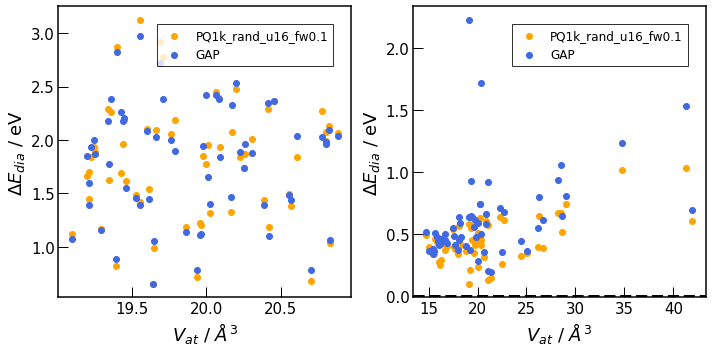

In [779]:
fig, (axs, axs2) = plot_rss(mtp_gr, labels=['PQ1k_rand_u16_fw0.1', 'GAP'],
                            col = list(reversed(['RoyalBlue', 'Orange'])))

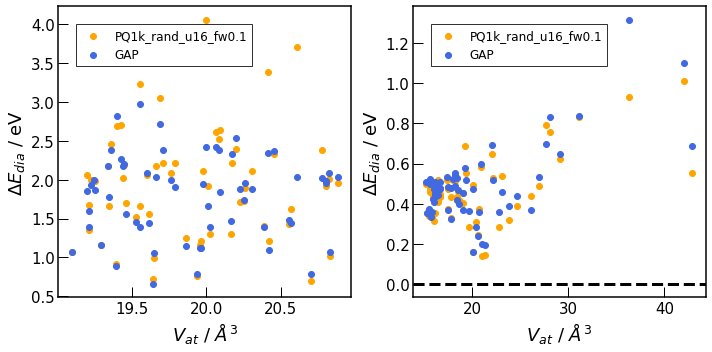

In [780]:
fig, (axs, axs2) = plot_rss(mtp_gr_g18_u24_fw0_1_direct, labels=['PQ1k_rand_u16_fw0.1', 'GAP'],
                            col = list(reversed(['RoyalBlue', 'Orange'])))

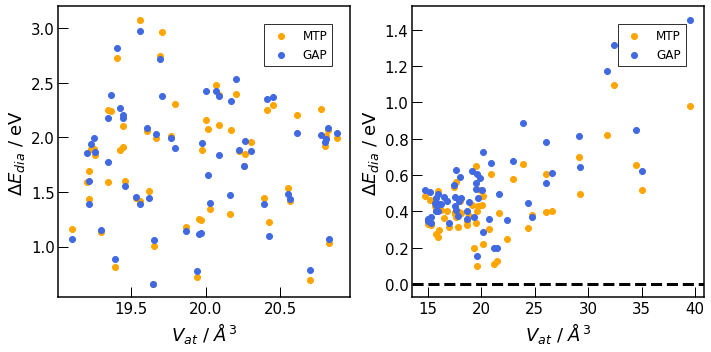

In [781]:
fig, (axs, axs2) = plot_rss(mtp_gr_PQ1k_1_10_g18_amo_u16_fw0_1, labels=['MTP', 'GAP'],
                            col = list(reversed(['RoyalBlue', 'Orange'])))

In [748]:
np.argmin(mtp_gr_PQ1k_1_10_g18_amo_u16_fw0_1[3][0])

13

In [765]:
with open('opts_mtp_gr_PQ1k_1_10_g18_amo_u16_fw0_1.xyz', 'w') as f:
    write_xyz(f, mtp_gr_PQ1k_1_10_g18_amo_u16_fw0_1[-2])


In [769]:
with open('opts_g18_sym.xyz', 'w') as f:
    write_xyz(f, sym_out[-1])

In [766]:
with open('opts_mtp_gr_g18_u24_fw0_1_direct.xyz', 'w') as f:
    write_xyz(f, mtp_gr_g18_u24_fw0_1_direct[-2])

In [711]:
print('unoptimised rms: ', rms_dict(s[0][0], s[1][0]))
print('optimised rms: ', rms_dict(s[2][0], s[3][0]))

unoptimised rms:  {'rmse': 1.3205801921640872, 'std': 4.358459332833527}
optimised rms:  {'rmse': 2.749090570255692, 'std': 38.235115883329165}


In [715]:
print('unoptimised median error per atom: ', np.median(abs(s[0][0] - s[1][0]))/8 )
print('optimised median error per atom: ', np.median(abs(s[2][0] - s[3][0]))/8 )

unoptimised median error:  0.07341625381735639
optimised median error:  0.05557955303657991


In [ ]:
targets = np.argwhere(vs_opt<26).T.squeeze()

In [232]:
non_exp = np.argwhere(vs_opt<26).T.squeeze()

In [678]:
print('optimised rms for V<26')
rms_dict(s[2][1][non_exp], s[3][1][non_exp])

optimised rms for V<26


{'rmse': 0.1340075770877777, 'std': 0.03530623630269002}

# Automatic buildcell routine

In [7]:
import sys; sys.path.append('/u/vld/hert5155/JDM_utils')

In [286]:
from ase.calculators import castep
from ase.io import castep as iocastep
from pyuoi.decomposition import CUR, UoI_CUR
import subprocess
from calc_utils import update_progress
from itertools import repeat

## Ideas for further development

**Selection algorithms:**
* CUR (fragment and configuration-averaged). Issue with non-determinism (average over lots of CUR selections?)
* FPS

**Modular decomposition:** read https://www.nature.com/articles/s41524-017-0035-x with reference to Phosphorus paper
* seed future searches

**Test case: MTP-RSS** from GAP for the Phosphorus potential, then try and discover the fibrous allotrope (big search)

**Parallelism** need a means for keeping track of the number of cores being used, running subprocesses with mpirun \ balanced with using the multiprocessing

### Basic outline
.\
.\
V

DFT-evaluation script (start with MTP-from-GAP for testing purposes, could try on Si, P, and C)

.\
.\
V

ML-training script

.\
.\
V

Overall iteration

In [187]:
os.chdir('Si_solid8')

In [42]:
# test.save('rsstest')

In [182]:
test = ML_RSS(MTPs_rmse_dict['PQ1k-1_g18_rand_u16_fw0.1'], 'py_buildcell')

buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell


In [188]:
test.load('rsstest')

In [36]:
# test.evaluate_set('rsstest', potentials=[g18])

([-650.5644361966891,
  -650.365716354269,
  -651.1077910848749,
  -650.6041437713062,
  -650.4003319589219,
  -649.5077408979201,
  -651.3764544397479,
  -650.7491170181743,
  -650.339568662108,
  -650.8157544324441,
  -650.9589439406416,
  -650.6740665967699,
  -650.8897623654552,
  -650.2265677828999,
  -649.2069209206072,
  -650.5893048996893,
  -650.4350315836804,
  -646.5614493392331,
  -650.9253036844997,
  -650.8943449456491,
  -650.6990543797895,
  -650.7000798851349,
  -650.6091248192015,
  -650.3306887401342,
  -650.4715565821481,
  -650.4778922740749,
  -650.9775041762499,
  -650.591498235388,
  -650.4870074032029,
  -647.6502972850027,
  -650.4793798817454,
  -649.6995737906431,
  -650.357253726359,
  -650.516167531282,
  -650.6532826293967,
  -650.4000648491075,
  -650.8066892739367,
  -648.8433625109764,
  -651.002746831599,
  -649.5222002266938,
  -651.2615568654863,
  -650.7768063088369,
  -650.9428924705728,
  -650.7003187595997,
  -651.0001303323942,
  -650.606307593

In [21]:
# test.buildcells(2000, ['VARVOL=20', 'MINSEP=2.0'], tag='rsstest',  atoms=[('Si1',4)])

Building cells...
Percent: [##############################] 99.95% 

In [22]:
# %%time
# test.optimise_set('rsstest', silent=True)

Percent: [##############################] 99.95% Optimisation summary:
 --------------------------------------------------
Min E =  -652.773480489007 
 --------------------------------------------------
N              nsteps         init           fina           delt           V /            
0              17             4.9514         2.1483         -2.8030        66.569         
1              21             6.2450         2.3774         -3.8677        88.080         
2              23             5.2088         1.5929         -3.6159        73.964         
3              20             6.2169         1.7738         -4.4431        83.707         
4              13             6.3123         2.2785         -4.0338        84.065         
5              21             6.9015         2.8683         -4.0332        94.841         
6              18             5.1390         0.9671         -4.1719        77.333         
7              15             5.5487         1.7692         -3.7796  

[Atoms(symbols='Si4', pbc=True, cell=[[2.859405424079174, 0.0, 0.0], [-1.20911841077177, 3.7924939142971748, 0.0], [-0.48035506131503247, -2.0160235061560674, 6.138608067425309]], castep_labels=..., initial_magmoms=..., calculator=MTP(...)),
 Atoms(symbols='Si4', pbc=True, cell=[[2.3407746813673183, 0.0, 0.0], [0.4218397854337645, 5.617908714418188, 0.0], [0.8342405898119003, 1.7911840361085691, 6.697931430835802]], castep_labels=..., initial_magmoms=..., calculator=MTP(...)),
 Atoms(symbols='Si4', pbc=True, cell=[[2.771270770138429, 0.0, 0.0], [-1.2318038020957032, 3.5486397783802075, 0.0], [-0.8569825746936023, -0.3820962031934915, 7.521089773000212]], castep_labels=..., initial_magmoms=..., calculator=MTP(...)),
 Atoms(symbols='Si4', pbc=True, cell=[[2.5489516662693417, 0.0, 0.0], [0.05773726845066393, 5.302000364515954, 0.0], [0.41193220371901146, 1.16315386149573, 6.193825696349881]], castep_labels=..., initial_magmoms=..., calculator=MTP(...)),
 Atoms(symbols='Si4', pbc=True, cel

In [194]:
sel = []
for i in range(100):
    sel.extend(select(test.optimised_atoms['rsstest'], 5))

array([1058, 1140,   16,  999, 1665])

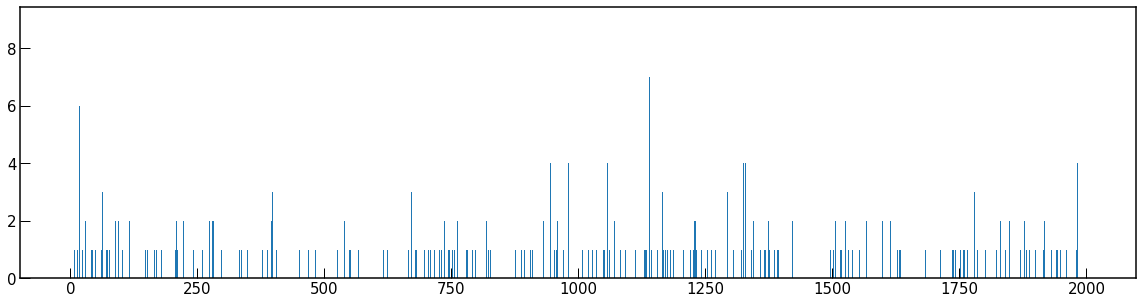

In [33]:
fig, axs = plt.subplots(figsize=(20,5))
h = axs.hist(sel, bins=len(test.optimised_atoms['rsstest']))
h[0].argsort()[-5:][::-1]

In [191]:
dia_ref = build.bulk('Si', crystalstructure='diamond')
dia_ref.calc = test.potential
e_ref = dia_ref.get_potential_energy()

In [192]:
dia_ref.calc = g18
g18_e_ref = dia_ref.get_potential_energy()

NameError: name 'h' is not defined

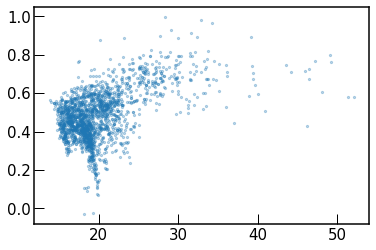

In [193]:
fig, axs = plt.subplots()
dat = test.opt_energies['rsstest']['PQ1k-1_g18_rand_u16_fw0.1']
axs.scatter(dat['v']/4, dat['e']/4 - e_ref/len(dia_ref), alpha=0.3, s=5)
axs.scatter(dat['v'][h[0].argsort()[-5:][::-1]]/4,
            dat['e'][h[0].argsort()[-5:][::-1]]/4 - e_ref/len(dia_ref))

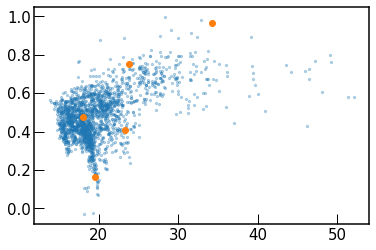

In [45]:
fig, axs = plt.subplots()
dat = test.opt_energies['rsstest']['PQ1k-1_g18_rand_u16_fw0.1']
axs.scatter(dat['v']/4, dat['e']/4 - e_ref/len(dia_ref), alpha=0.3, s=5)
axs.scatter(dat['v'][h[0].argsort()[-5:][::-1]]/4,
            dat['e'][h[0].argsort()[-5:][::-1]]/4 - e_ref/len(dia_ref))

In [48]:
test.opt_energies['rsstest'].keys()

dict_keys(['PQ1k-1_g18_rand_u16_fw0.1', 'tag_0'])

[Text(0.5, 0, 'GAP-18 E / eV'), Text(0, 0.5, 'MTP E / eV')]

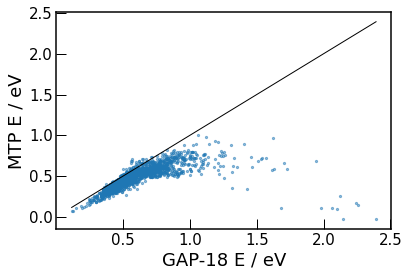

In [56]:
fig, axs = plt.subplots()

axs.scatter(x := test.opt_energies['rsstest']['tag_0']['e']/4 - g18_e_ref/2,
            test.opt_energies['rsstest']['PQ1k-1_g18_rand_u16_fw0.1']['e']/4 - e_ref/2,
           alpha=0.5, s=5)
axs.plot(x := np.linspace(x.min(), x.max(), 100), x, color='k', linewidth=1)
axs.set(xlabel='GAP-18 E / eV', ylabel='MTP E / eV')

# MP crystals

In [59]:
with mp.MPRester("v0JVgKLlpTXKEhiKeDIC") as m:
    results = m.query(criteria={"pretty_formula":'Si'},
                            properties=["exp.tags", "icsd_ids", "spacegroup",
                                        "task_id", "density", "final_structure",
                                        "e_above_hull", "energy", "energy_per_atom"])

mp_xtals = [pase.AseAtomsAdaptor().get_atoms(
            SpacegroupAnalyzer(i['final_structure']).get_conventional_standard_structure())
            for i in results]

In [60]:
test_mp_k = kernel_compare(test.optimised_atoms['rsstest'], mp_xtals, similarity=True)

(2000, 1, 547) (39, 1, 547)


In [62]:
np.argwhere(test_mp_k[:,:]>0.995)

array([[   5,  306],
       [   6, 1594],
       [  26,   56],
       [  26,  324],
       [  26,  755],
       [  26, 1015],
       [  28,  978],
       [  34,   76],
       [  34,  306],
       [  34,  375],
       [  34,  738],
       [  34, 1188],
       [  34, 1244],
       [  34, 1320],
       [  34, 1511],
       [  34, 1587],
       [  34, 1911],
       [  35,  375],
       [  35,  738],
       [  35, 1188],
       [  35, 1244],
       [  35, 1320],
       [  35, 1373],
       [  35, 1511]])

In [77]:
np.argmax(test_mp_k[19:,274])

12

In [71]:
np.argmin(test.opt_energies['rsstest']['tag_0']['e'])

274

# Exploring relationship with crystal structures - id fragments

In [298]:
with open('/u/vld/hert5155/jup_remote/Ge_analysis/xtals_for_SOAP.pickle', 'rb') as f:
    xtals = pickle.load(f)

In [299]:
xtals = [i[0] for i in xtals]
comp_labels = ['fcc', 'dia', 'hcp', 'bcc', 'sc', 'sh', 'bSn', 'Imma', 'Cmca']

In [625]:
ks = kernel_compare(opts, xtals, average=True, similarity=True,
                   desc='soap l_max=6 n_max=12 \
                    atom_sigma=0.3 cutoff=3.0 \
                    cutoff_transition_width=1.0 central_weight=1.0')

(61, 1, 547) (9, 1, 547)


In [626]:
ks_nav = kernel_compare(opts, xtals, average=False, similarity=True,
                        desc='soap l_max=6 n_max=12 \
                    atom_sigma=0.3 cutoff=3.0 \
                    cutoff_transition_width=1.0 central_weight=1.0')

(61, 8, 547) (9, 1, 547)


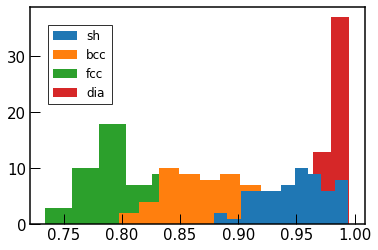

In [628]:

fig, axs = plt.subplots()
for ct,i in enumerate([5,3,0,1]):
#     axs.scatter(vs_opt, ks[i], label=comp_labels[i])
    axs.hist(ks[i], label=comp_labels[i], zorder=-ct)

axs.legend()

In [343]:
np.argmax(ks[1]), np.argmax(ks[3]) # look for the most diamond-like ones

(41, 57)

In [362]:
v = view(opts[41], viewer='ngl', repeat=[2,2,2]).view

In [364]:
v.add_ball_and_stick()

In [365]:
v

NGLWidget()

In [679]:
v = view(opts[57], viewer='ngl', repeat=[2,2,2]).view; v.add_ball_and_stick(); v.observe(on_picked_change, 'picked'); v

NGLWidget()

In [402]:
from ipywidgets import Output, VBox
import nglview as nv

out = Output(layout={'border': '2px solid red'})

def on_picked_change(b):
    with out:
        try:
            print(b['new']['atom1']['index'])
        except:
            print()

In [421]:
at = opts[56].copy()
opts[56][1].number = 32
opts[56][2].number = 33

Highlight the most diamond-like atoms

In [680]:
out = Output(layout={'border': '2px solid red'})
v = view(opts[56], viewer='ngl', block=True, repeat=[3,3,3]).view
v.observe(on_picked_change, 'picked')
v.add_ball_and_stick()
display(VBox([v, out]))

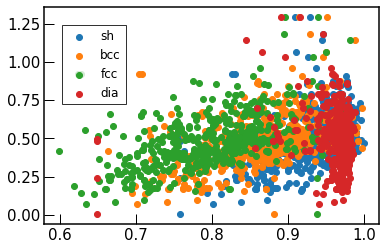

In [631]:
fig, axs = plt.subplots()
for ct,i in enumerate([5,3,0,1]):
    axs.scatter(ks_nav[i], s[2][3] - s[4][0]/len(dia_ref), label=comp_labels[i])

axs.legend()

In [657]:
low_e_xtals_ind = np.argwhere(s[2][3] - s[4][0]/len(dia_ref) < 0.15) # get low energy atoms

In [655]:
# get low energy doublets of atoms (must be all within 3A of eachother)

low_e_xtals_ind_looser = np.argwhere(s[2][3] - s[4][0]/len(dia_ref) < 0.3)

for 

In [656]:
low_e_xtals_ind

array([[ 0,  7],
       [ 1,  0],
       [ 1,  6],
       [ 2,  1],
       [ 2,  3],
       [ 2,  5],
       [ 2,  6],
       [ 5,  2],
       [ 6,  2],
       [ 6,  6],
       [11,  2],
       [11,  3],
       [13,  2],
       [13,  4],
       [13,  7],
       [14,  0],
       [14,  5],
       [15,  0],
       [15,  2],
       [16,  1],
       [16,  2],
       [16,  6],
       [16,  7],
       [18,  1],
       [18,  3],
       [18,  4],
       [18,  6],
       [18,  7],
       [19,  5],
       [20,  1],
       [26,  6],
       [26,  7],
       [30,  4],
       [30,  5],
       [31,  2],
       [31,  3],
       [34,  1],
       [35,  0],
       [35,  3],
       [37,  4],
       [38,  0],
       [38,  1],
       [38,  3],
       [38,  6],
       [41,  2],
       [46,  1],
       [46,  2],
       [46,  6],
       [47,  2],
       [53,  1],
       [53,  5],
       [55,  0],
       [55,  3],
       [55,  4],
       [55,  5],
       [56,  1],
       [56,  2],
       [56,  3],
       [56,  4

## extract the diamond-like environments for structure seeding:

In [661]:
frags = []
for i, inds in enumerate(low_e_xtals_ind):
    t = opts[inds[0]].copy()
    t.numbers = [14 for i in range(len(t))]
    st = supercells.make_supercell(t, 2*np.identity(3))
    nl = build_neighbor_list(st, cutoffs=[2.9/2 for i in range(len(st))])
    cm = nl.get_connectivity_matrix().toarray() # define fragment's immediate environment
    
    st.positions -= (st.positions[inds[1]] - st.cell.cellpar()[0:3]/2) # centre the fragment
    st.wrap()
    
    
    pos = st.positions[cm[inds[1],:]>0] # extract fragment's immediate environment
    st[inds[1]].number = 32
    nums = st.numbers[cm[inds[1],:]>0] # colour central atom
    
    
    frag = Atoms(numbers=nums,
                 positions=pos, pbc=False, cell=[10,10,10])
    
    frags.append(frag)

In [662]:
frags[-1].positions

array([[4.88297785, 5.53773071, 6.32534437],
       [5.09347829, 4.09365012, 3.19524165],
       [3.35428081, 6.45384834, 4.84869849],
       [6.54075433, 4.76487095, 4.886074  ],
       [3.82142695, 3.71138588, 7.40805384],
       [5.83451638, 7.42007585, 7.32459026],
       [7.04437892, 2.81539678, 6.02098844],
       [4.97395179, 7.20306413, 3.28282556]])

In [663]:
at = frags[-1]
v = view(at, viewer='ngl').view; v.add_ball_and_stick(); v.add_unitcell(); v

NGLWidget()

In [425]:
ks_nav[1][56, 1]

0.8023557976214413

In [585]:
from ase.build import supercells
from ase.neighborlist import NeighborList, build_neighbor_list, natural_cutoffs

In [586]:
t = opts[56].copy()

In [599]:
st = supercells.make_supercell(t, 2*np.identity(3))

In [607]:
st[2]

Atom('As', [4.882977851253761, 5.537730705589761, 6.32534436552998], magmom=0.0, index=2)

In [616]:
nl56 = build_neighbor_list(st, cutoffs=[2.9/2 for i in range(len(st))])

In [617]:
cm = nl56.get_connectivity_matrix().toarray()

In [619]:
cm[2,:]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8)

In [604]:
st.cell.cellpar(), st.cell

(array([ 9.7659557 , 11.07546141, 12.65068873, 89.39991   , 70.89921   ,
        84.53399   ]),
 Cell([[9.765955702507522, 0.0, 0.0], [1.0549956176980122, 11.025099986719606, 0.0], [4.139696613292784, -0.26302862081165745, 11.951303412795344]]))

In [605]:
st.positions -= (st.positions[2] - st.cell.cellpar()[0:3]/2)

In [606]:
st.wrap()

In [620]:
pos = st.positions[cm[2,:]>0]

In [621]:
frag = Atoms(symbols='Si{}'.format(len(pos)), positions=pos, pbc=False, cell=[10,10,10])

In [622]:
v = view(frag, viewer='ngl').view; v.add_ball_and_stick(); v

NGLWidget()

In [332]:
def atoms_to_json(aseatoms, infer_bonds=True):
    '''
    Convert ASE Atoms isntance into the json format compatible with

    Args:
        aseatoms : ase.Atoms
            Instance of Atoms from ase package
        infer_bonds : bool
            If `True` bonds will be inferred using openbabel

    Returns:
        mol : dist
            A dictionary with the json format of the molecule
    '''

    import pybel
    ob = pybel.ob

    obmol = ob.OBMol()
    obmol.BeginModify()

    for atom in aseatoms:
        obatom = obmol.NewAtom()
        obatom.SetAtomicNum(int(atom.number))
        obatom.SetVector(*atom.position.tolist())

    # If there is no bond data, try to infer them
    if infer_bonds:
        obmol.ConnectTheDots()
        obmol.PerceiveBondOrders()

    # Check for unit cell data
    if any(aseatoms.pbc):
        uc = ob.OBUnitCell()
        uc.SetData(*(ob.vector3(*v) for v in aseatoms.get_cell()))
        uc.SetSpaceGroup('P1')
        obmol.CloneData(uc)
    obmol.EndModify()

    mol = pybel.Molecule(obmol)

    return imolecule.format_converter.pybel_to_json(mol)


## need to check that ase-opt reflects quip-opt

In [ ]:
from ase.calculators import castep
from ase.io import castep as iocastep
import os
import numpy as np
from copy import deepcopy
import pickle
from glob import glob
from re import findall

tag = 'Si_g18opt'
files = sorted(glob(tag+'*'), key=lambda f: int(findall('\d+', f)[-1]))
print('sorted files:', files)

directory = './Si_g18opt'
ats = []
inits = []
for i in files:
    with open(i, 'r') as f:
        inits.append(iocastep.read_cell(f))
i = 0 

for ct, val in enumerate(inits):
    calc = castep.Castep(castep_command='mpirun -np $NMPI /usr/local/CASTEP-20/castep.mpi')
    calc._prepare_input_only=True
    val.calc = calc

    calc.set_kpts({'spacing' : 0.05})
    calc.merge_param('/u/vld/hert5155/scripts/castep/template.param')
    calc.param.elec_energy_tol = 1e-5
    calc.param.xc_functional = 'PW91'

    calc._directory = directory
    calc._rename_existing_dir = False
    calc._label = '{}_{}'.format(tag, ct+1) # start label indexing from 1, currently
    print('\n{}\n'.format(calc._label))

    out = None
    
    if os.path.isdir(directory): # check if calculation is a restart (i.e. already done')
        if calc._label + '.castep' in os.listdir(directory):
            try:
                out = iocastep.read_seed(os.path.join(directory, calc._label))
                print('Existing .castep found and read. Warnings associated: {}'.format(out.calc._warnings))
            except:
                print('.castep found, but can\'t be read correctly so reoptimising geometry')

    if out is None:
        if calc.dryrun_ok():
            print('%s : %s ' % (val.calc._label, val.get_potential_energy()))
            out = iocastep.read_seed(os.path.join(directory, calc._label))
        else:
            print("Found error in input")
            print(calc._error)
    


# Fragment identification work

In [362]:
class ML_RSS:
    
    def __init__(self, potential, directory, buildcell_command='buildcell'):
        '''
        Parameters:
        potential
        directory
        buildcell command'''
        self.potential = potential
        self.buildcell_command = which(buildcell_command)
        print('buildcell command is {}'.format(self.buildcell_command))
        self.directory = directory
        self.init_atoms = {}
        self.optimised_atoms = {}; self.failed = {}
        self.opt_energies = {}
        self.unopt_energies = {}
        
        if not os.path.isdir(directory):
            os.mkdir(directory)
        
        
        
    def buildcells(self, N, buildcell_options,
                   atoms=[('Si1',8)], tag='rss', timeout=100):
        '''Prepares random cells in self.directory
        Arguments:
        N :: number of cells to make
        buildcell options :: format e.g. VARVOL=20, end-of-file directives to buildcell
        atoms :: list of tuples for atom and number to include, e.g. [(Mo1,1), (S1,3
        tag   :: prefix for all files
        timeout :: timeout for buildcell / s)]'''
        
        at = Atoms(symbols=''.join([i[0][:-1] for i in atoms]),
                  cell=np.identity(3)*2, pbc=True,
                   positions=np.zeros((len(atoms), 3))
                  )
        bc_file = join(self.directory,'{}.cell'.format(tag))
        
        
        #### writing the master buildcell ########################
        
        write_cell(bc_file, at, positions_frac=True)
        
        with open(bc_file, 'r') as f:
            contents = f.readlines()
        
        flag = 0; ct = 0
        for i, val in enumerate(contents):
            if '%BLOCK POSITIONS_FRAC' in val:
                flag=1
            elif '%ENDBLOCK POSITIONS_FRAC' in val:
                flag=0
            elif flag==1:
                contents[i] = val.strip('\n') + ' # {} % NUM={}\n'.format(atoms[ct][0], atoms[ct][1])
                ct+=1
                
            
        contents.extend(['#' + i + '\n' for i in buildcell_options])
        
        with open(bc_file, 'w') as f:
            f.writelines(contents)
        
        print('Building cells...')
        for i in range(N):
            buildcell_command = [self.buildcell_command, '<', bc_file,
                             '>', join(self.directory, '{}_{}.cell'.format(tag, i))] 
            buildcell_command = ''.join(buildcell_command)

            out = subprocess.run(buildcell_command, shell=True, capture_output=True, text=True,
                                 timeout=timeout, check=True)
        
            update_progress((i+1)/N)
        
        self.init_atoms[tag] = [read_cell(join(self.directory, '{}_{}.cell'.format(tag, i))) for i in range(N)]
        for i in range(N):
            os.remove('{}_{}.cell'.format(tag, i))
       
    
    def optimise_set(self, tag, steps=100, P=0, fmax=5e-2, write_trajectory=True, traj='/dev/null',
                     silent=False, name='NA', evaluate=True, check_convergence=True, parallel=False):
        '''Arguments
        steps :: max number of relaxation steps
        P     :: pressure / eVA^-3
        fmax  :: force convergene tolerance
        traj  :: trajectory file for opt
        silent:: silence optimisation output
        Returns 
        optimised geometries (Atoms object)'''
        

        if tag not in self.init_atoms:
            print('not reading init atoms')
            self.init_atoms[tag] = [read_cell(join(self.directory, i)) for i in glob('{}_*.cell'.format(tag))]
#             ats_to_opt = self.init_atoms[tag]
            
        self.optimised_atoms.update({tag:[]}); self.failed = {tag:[]}
        nsteps = []; init_e = []; final_e = []; del_e = []; v = []
        N = len(self.init_atoms[tag])
        
        startTime = datetime.now()
        
        if parallel:

            uo_atoms = deepcopy(self.init_atoms[tag])
            o_atoms, nsteps = self.parallel_opt(uo_atoms, nprocs, steps, P,
                                        fmax, write_trajectory, traj, silent, name, check_convergence)
            
        else:
            o_atoms = []
            for ct, uo_atoms in enumerate(self.init_atoms[tag]):

                if write_trajectory:
                    traj=tag + '_{}.traj'.format(ct)

                at = uo_atoms.copy()
                at.calc = self.potential

                at, n_opt = self._opt(at, steps, P, fmax, write_trajectory, traj, silent, name, check_convergence)
    
                if check_convergence and not n_opt.converged():
                    self.failed[tag].append(ct)
                nsteps.append(n_opt.get_number_of_steps())
                
                o_atoms.append(at)
                update_progress((ct+1)/N)
            
        for ct, at in enumerate(o_atoms):
            self.init_atoms[tag][ct].calc = self.potential
            at.calc = self.potential
            init_e.append(self.init_atoms[tag][ct].get_potential_energy())
            final_e.append(at.get_potential_energy())
            v.append(at.get_volume())          
            at.calc = None; self.init_atoms[tag][ct].calc = None
            self.optimised_atoms[tag].append(at.copy())
    
       
        
        if evaluate:
            tmp = self.evaluate_set(tag, potentials=[self.potential])
        
        final_e = np.array(final_e)
        init_e = np.array(init_e)
        min_e = final_e.min()
        final_e = final_e - min_e
        init_e = init_e - min_e
        del_e = final_e - init_e
        print('Optimisation summary:\n', '-'*50)
        print('Walltime: ', datetime.now() - startTime)
        print('Min E = ', min_e,'\n','-'*50)
        print('{:<15s}{:<15s}{:<15.4s}{:<15.4s}{:<15.4s}{:<15.3s}'.format(
                r'N', r'nsteps', r'init E / eV', r'final E / eV', 'delta E / eV', 'V / A^3'))
        for i in range(len(self.optimised_atoms[tag])):
            print('{:<15d}{:<15d}{:<15.4f}{:<15.4f}{:<15.4f}{:<15.3f}'.format(
                i, nsteps[i], init_e[i], final_e[i], del_e[i], v[i]))
        
        return self.optimised_atoms[tag]
    
    def parallel_opt(self, atoms, nprocs, steps=100, P=0, fmax=5e-2, write_trajectory=True, traj='/dev/null',
                     silent=False, name='NA', check_convergence=True):

        args = []
        constant_args = [steps, P, fmax, write_trajectory, traj, silent, name, check_convergence, False]
        for i in atoms:
            args.append( tuple([i]+constant_args) )
        
        if __name__ == '__main__':    
            for i in atoms:
                    i.calc = self.potential
        
       
            with Pool(nprocs) as p:
                opt_atoms, nsteps = zip(*p.starmap(
                   
                    #partial(self._opt, steps, P, fmax, write_trajectory, traj, silent, name, check_convergence)
                    self._opt, args))
#                 opt_atoms = [i[0] for i in res]
#                 nsteps = [i[1] for i in res]
        
            for i in atoms:
                i.calc = None
        else:
            raise NameError('Not in __main__')
        
        return opt_atoms, nsteps
    
    def save(self, tag, evals=True):

        with open(join(self.directory,'{}_opt_geom'.format(tag)), 'wb') as f:
            pickle.dump([self.init_atoms, self.optimised_atoms], f)
        
        if evals:
            with open(join(self.directory,'{}_evals'.format(tag)), 'wb') as f:
                pickle.dump([self.opt_energies, self.unopt_energies], f)
        return
        
        
    def load(self, tag, evals=True):
    
        with open(join(self.directory,'{}_opt_geom'.format(tag)), 'rb') as f:
            self.init_atoms, self.optimised_atoms = pickle.load(f)
        
        if evals:
            with open(join(self.directory,'{}_evals'.format(tag)), 'rb') as f:
                self.opt_energies, self.unopt_energies = pickle.load(f)
        return
        

    def _opt(self, at, steps=100, P=0, fmax=5e-2, write_trajectory=True, traj='/dev/null',
                     silent=False, name='NA', check_convergence=True, return_opt=True):
        '''single-structure optimisation routine'''

        #at.set_constraint(FixAtoms(mask=[True for atom in at]))

        uf = ExpCellFilter(at, scalar_pressure=P, hydrostatic_strain=True) # should ensure only the lattice can move, not atomic positions
        
        if silent:
            opt = BFGSLineSearch(atoms=uf, trajectory=traj, logfile='/dev/null')
        else:
            opt = BFGSLineSearch(atoms=uf, trajectory=traj)

        opt.run(fmax, steps=steps) # converge to 0.1 GPa

        if check_convergence and not opt.converged():
            warnings.warn(('Warning: failed to converge on structure{}\n' +\
                          'in {} steps').format(name, steps))
            #at.set_cell(np.NaN*np.ones(3)) # flag unconverged geometry
        
        if return_opt:
            return at, opt
        else:
            nsteps = opt.get_number_of_steps()
            return at, nsteps
        
    
    def evaluate_set(self, tag, potentials=[], opt=True, label_set=False, parallel=True):
        
        if opt:
            if tag not in self.opt_energies:
                self.opt_energies.update({tag:{}})
            e_dict = self.opt_energies
            atoms = self.optimised_atoms[tag]
        else:
            if tag not in self.unopt_energies:
                self.unopt_energies.update({tag:{}})
            e_dict = self.unopt_energies
            atoms = self.init_atoms[tag]
            
        for pct, pot in enumerate(potentials):
            
            if not hasattr(pot, 'name') or pot.name == '' or pot.name is None:
                pot.name = 'tag_{}'.format(pct)
                
            cct=0
            if isinstance(pot, Castep):
                pot.label += '_0'
                
            
            es = []; fs = []; ss = []; e_ats = []; vs = []
        
            if parallel:
                args = []
                constant_args = [pot]
                cct = np.arange(len(atoms))
                
                for i, val in enumerate(atoms):
                    args.append( tuple([val]+constant_args+[cct[i]]) )

                if __name__ == '__main__':    

                    with Pool(nprocs) as p:
                        es, fs, ss, vs, e_ats = zip(*p.starmap(self._evaluate_atoms, args))

                else:
                    raise NameError('Not in __main__')
        
            else:
                for act, at in enumerate(atoms):
                        
                    e, f, s, v, e_at = self._evaluate_atoms(at, pot, cct=cct)
                    es.append(e)
                    fs.append(f)
                    ss.append(s)   
                    vs.append(v)
                    e_ats.append(e_ats)
                    cct += 1 # for Castep labels, otherwise does nothing
                    
            e_dict[tag][pot.name] = {'e':np.array(es), 'f':np.array(fs),
                                     's':np.array(ss), 'es':np.array(e_ats),
                                     'v':np.array(vs)}
        
        if label_set:
            print('label set not implemented')
            pass
            
        return
    
    def _evaluate_atoms(self, at, pot, cct=None):
        
        if isinstance(pot, Castep): # file-naming scheme for Castep calculations
                        pot._label = pot._label.split('_')[:-1] + '_' +  cct
                    
        at.calc = pot
        es= at.get_potential_energy()
        f = at.get_forces()
        s = at.get_stress()   
        v = at.get_volume()
        if 'energies' in pot.implemented_properties:
            e_at = at.get_potential_energies()
        else:
            e_at = np.NaN
                        
        at.calc = None
        
        return e, f, s, v, e_at
    
    def label_set(self, tag, potential, opt=True):
        
        if opt:
            if tag not in self.opt_energies:
                raise AttributeError('no energies for tag {}\nneed to run evaluate_set first'.format(
                tag))
            e_dict = self.opt_energies[tag][potential.name]
            atoms = self.optimised_atoms[tag]
        else:
            if tag not in self.unopt_energies:
                raise AttributeError('no energies for tag {}\nneed to run evaluate_set first'.format(
                tag))
            e_dict = self.unopt_energies[tag][potential.name]
            atoms = self.init_atoms[tag]
            
        a=atoms.copy()
        alen = len(a)
        for act in range(alen):
            a[act].info['energy'] = e_dict['e'][act]
            a[act].info['stress'] = e_dict['s'][act]
            a[act].info['virial'] = -1*e_dict['s'][act]*e_dict['v'][act] # make sure is right!
            a[act].arrays['forces'] = e_dict['f'][act]
            
        return a
            
        
            
    def calc_ref():
        return
    
    def dft_set():
        return
    
    def select():
        return
    
    def plot_rss(self, tag, labels=['opt', 'eval'], eval_pot=True,
                 axs=None, maxvol=26, col=['RoyalBlue', 'Orange']):
    
        if axs is None:
            fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
        else:
            fig = axs.figure
        s = gap_rss_out


        opts = s[5]
        ref = s[4]
        cs = s[-1]
        vs_opt = np.array([i.get_volume()/len(i) for i in self.optimise_set])
        vs_unopt = np.array([i.get_volume()/len(i) for i in cs])
        non_exp = np.argwhere(vs_opt<maxvol).T.squeeze()

        axs.scatter(vs_unopt, s[0][0]/len(opts[0]) - ref[0]/len(dia_ref), label=labels[0], color=col[0])
        if eval_pot:
            axs.scatter(vs_unopt, s[1][0]/len(opts[0]) - ref[1]/len(dia_ref), label=labels[1], color=col[1])
        axs.legend()
        axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')

        axs2.scatter(vs_opt, s[2][0]/len(opts[0]) - ref[0]/len(dia_ref), label=labels[0], color=col[0])
        if eval_pot:
            axs2.scatter(vs_opt, s[3][0]/len(opts[0]) - ref[1]/len(dia_ref), label=labels[1], color=col[1])
        axs2.legend()
        axs2.axhline(0, color='k', linestyle='--')
        axs2.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')

        fig.tight_layout()

        return fig, (axs, axs2)
        

            
        
        

In [10]:
def calc_similarity(atoms, descriptor=None, zeta=2):
    '''Could read zeta from descriptor specified and use this
    in kernel construction. If construction of the outer product
    is slow, could speed up by taking advantage of symmetry and
    broadcasting'''
    if not descriptor:
        descriptor = quippy.descriptors.Descriptor(
                         'soap average=T l_max=6 n_max=12 atom_sigma=1.0 \
                          cutoff=5.0 cutoff_transition_width=1.0 \
                          central_weight=1.0')
    descs = np.array(descriptor.calc_descriptor(atoms))

    
    
    k = np.array(2 - 2*np.einsum('i...j,k...j', descs, descs)**zeta) # compute dot-product kernel

    
    return k.squeeze()

In [253]:
def select(atoms, N, algorithm='CUR', descriptor=None, zeta=2):
    '''Select atoms based on algorithm
    Returns: selected atom indices
    
    TODO: implement averaging over many CUR selections'''
    
    if algorithm == 'all':
        selection = np.arange(len(atoms))
    
    elif algorithm == 'CUR':
        k = calc_similarity(atoms, descriptor, zeta)

        cur = CUR(int(np.sqrt(N)), algorithm='arpack')
        cur.fit(k, c=N)

        selection = cur.column_indices_
        
    
        
    return selection

In [12]:
def train_gap(pot_name):
    
    return

## With training MTPs

include facility for training of multiple potentials and selection of the best-performing one

In [319]:
def train_mtp(pot_name,
              db,
              test_set,
              init,
              mlp_command,
              n=1,
              options=[],
              hpc_commands=['module load intel/2015', 'module load mpich3-intel'],
              timeout=36000,
             silent=False):
    '''
    Returns: new_pot (Calculator object)
             rmses, [e, f, s] list
    TODO: '''
    if not silent:
        print('training MTP {}.mtp'.format(pot_name), )
    for i in hpc_commands:
        os.system(i)
    
    for i in range(n):
        if not silent:
            print(i+1,'...', end='')
        command = [mlp_command, 'train', init, db, '--trained-pot-name={}_{}.mtp'.format(pot_name, i)] + options 
        out = subprocess.run(command, capture_output=True, text=True, timeout=timeout)
        if not silent:
            print('Done')
    
    chosen_mtp, rmses = choose_mtp(pot_name, test_set, n, skip=False)
    new_pot = MTP(chosen_mtp, train=db, parallel=False)
    

    
    return new_pot, rmses

In [267]:
def choose_mtp(pot_name, test_set, n, skip=True):
    '''
    Returns: new_pot (str)
             rmses, [e, f, s] list
             
    TODO: calc-efs bulk on the training sets for serious performance enhancement,
    could do in parallel too'''
    MTPs = []; es = []; fs = []; ss = []
    
    if skip:
        return MTP('{}_{}'.format(i, pot_name+'.mtp'), parallel=False)
    
    for i in range(n):
        MTPs.append(MTP('{}_{}.mtp'.format(pot_name, i), parallel=False))
        rmse_model = Model(MTPs[-1], test_set)
        rmse_model.efs_calc()
        rmse_model.efs_read(cfgs='reference', energy_name='energy', force_name='forces', stress_name='virial')
#         print(rmse_model.flat_fs)
        print(rmse_model.train_es)
        rmse_model.rmse()
        es.append(rmse_model.rmses['energy_test']['rmse'])
        fs.append(rmse_model.rmses['force_test']['rmse'])
        ss.append(rmse_model.rmses['stress_test']['rmse'])
        
    es = np.array(es)
    
    choice = np.argmin(es)
    s = MTPs[choice].potential_file
    rmses = [es[choice], fs[choice], ss[choice]]
    
        
    print('MTP {} selected'.format(s))
    return s, rmses

In [358]:
from ase.calculators.castep import Castep

class Castep_RSS(Castep):

    def __init__(self, castep_command, directory, label, kpt_spacing, param_file, P=0):
        '''Initialises a castep calculator object for RSS
        MPI-only'''

        if 'OMP_NUM_THREADS' not in os.environ:
            if int(os.environ['OMP_NUM_THREADS']) != 1:
                print('Warning, OMP not supported, OMP_THREADS should be 1 but is {}'.format(
                      os.environ['OMP_NUM_THREADS']))

        self.castep_command=castep_command
        

        self.cell.external_pressure = 'GPa ! Units optional\n'\
        '{} 0.0 0.0 ! Isotropic presssure of 4GPa\n'\
        '{} 0.0 ! Only upper half of 3x3 matrix specified\n'\
        '{} ! Castep makes symetric lower half\n'.format(P, P, P)

        self.set_kpts({'spacing' : 0.08})
        self.merge_param(param)

        self._directory = directory
        self._rename_existing_dir = False
        self._label = label
        self.name = 'castep_'+label
        
        print('Castep calculator {} initialised\n'.format(calc._label))
        
    def __deepcopy__(self):
        return Castep_RSS(self.castep_command, self.directory, self.label,
                          self.kpt_spacing, self.param_file, self.P)
    

In [85]:
def castep_initialise(castep_command, directory, label, kpt_spacing, param_file, P=0):
    '''Initialises a castep calculator object for RSS
    MPI-only'''
    
    if 'OMP_NUM_THREADS' not in os.environ:
        if int(os.environ['OMP_NUM_THREADS']) != 1:
            print('Warning, OMP not supported, OMP_THREADS should be 1 but is {}'.format(
                  os.environ['OMP_NUM_THREADS']))
    
    calc = castep.Castep(castep_command=castep_command)
    
    calc.cell.external_pressure = 'GPa ! Units optional\n'\
    '{} 0.0 0.0 ! Isotropic presssure of 4GPa\n'\
    '{} 0.0 ! Only upper half of 3x3 matrix specified\n'\
    '{} ! Castep makes symetric lower half\n'.format(P, P, P)
    
    calc.set_kpts({'spacing' : 0.08})
    calc.merge_param(param)
    
    calc._directory = directory
    calc._rename_existing_dir = False
    calc._label = label
    print('Castep calculator {} initialised\n'.format(calc._label))
    
    
    return calc

In [ ]:
def rss_iterate():
    return

In [88]:
os.chdir('/home/tridymite/vld/hert5155/jup_remote/Ge_od/rss/auto_rss')

# Core RSS logic:

In [282]:
import multiprocessing
from multiprocessing import Pool

In [281]:
'''TODO:
parallel optimisation of geometries and calculation of energies (using simple imap)'''

'TODO:\nparallel optimisation of geometries and calculation of energies (using simple imap)'

In [283]:
multiprocessing.cpu_count()

6

In [359]:
### ML-RSS parameters ###
n_gens = 2 # number of generations (not including init).
# last generation gets iterated until target RMSE reached
init_mtp = MTP('init.mtp', parallel=False)
N_cells = [30, 20, 20]
buildcell_options = [['VARVOL=20', 'MINSEP=2.0'] for i in range(n_gens+1)]
buildcell_atoms=[[('Si1',4)] for i in range(n_gens+1)]
m_tag='auto_rss2'
ref_method=g18
train_method = train_mtp
train_method_args = ('init.mtp', '/home/tridymite/vld/hert5155/mlip-2/bin/mlp', 5
                    ) # arguments after the 2nd (all train methods have pot_name, db as first)
keep_steps = [[0], (5, 200), [200]]
select_opts = [['all', 1], ['all', 1], ['CUR', 0.5]]
pressure = 0
target_rmse = 0.02; max_iter = 1; rmse_conv_tol = 4e-3

#### Parallelisation settings ###
if 'NSLOTS' in os.environ.keys():
    nprocs = os.environ['NSLOTS']
else:
    nprocs = 4

In [363]:
## initialise ##
dbs = []; pots = []; full_db = []; full_db_test = []
log = [] # list of dictionaries containing information from each generation
tag = m_tag + '_init'
test_tag = tag+'_test'
log.append({'name':tag, 'iter':0})

init_rss = ML_RSS(ref_method, '.')

### For testing and training sets:

for i in [tag, test_tag]:
    init_rss.buildcells(N_cells[0], buildcell_options[0], buildcell_atoms[0], i, timeout=100)
    init_rss.evaluate_set(i, opt=False, potentials=[ref_method], parallel=False)
    init_rss.save(i)
init_db = init_rss.label_set(tag, ref_method, opt=False)
test_db = init_rss.label_set(test_tag, ref_method, opt=False)
dbs.append((init_db, test_db))
full_db.extend(init_db)

write_cfg_db(tag+'.cfg', init_db, force_name='forces',
                              virial_name='virial',
                              energy_name='energy')


init_pot, rmses = train_method(tag, tag+'.cfg', test_db, *train_method_args)
log[-1]['rmses'] = rmses
curr_pot = init_pot
pots.append(init_pot)

buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell
Building cells...
Percent: [##############################] 100.00% Done...


NameError: name 'e' is not defined

In [344]:
'''TODO: wasteful reoptimisation of first N set of keep_steps'''
g=0; g_ct=0 # generation specification number (see input), generation counter
while g_ct < max_iter:
    g_ct += 1
    if g < n_gens:
        g=g_ct
    else:
        g=-1 # iterate to convergence on the final generation specification
    
    print('Beginning generation ', g, 'totoal iteration ', g_ct)
    tag = '{}_gen{}'.format(m_tag, g_ct)
    test_tag = '{}_gen{}_test'.format(m_tag, g_ct)
    log.append({'name':tag, 'iter':g_ct})
    
    ml_rss = ML_RSS(curr_pot, '.')
    
    for t in [tag, test_tag]:
        print('Starting ', t)
        ml_rss.buildcells(N_cells[g], buildcell_options[g], buildcell_atoms[g], tag=t, timeout=100)
        
        ats = []
        for sct, steps in enumerate(keep_steps[g]):

            s_remain = steps-sum(keep_steps[g][0:sct]); print('\n',s_remain)
            
            print('Optimising {} set for {} steps'.format(t, steps))
            
            ml_rss.optimise_set(t, steps=s_remain, P=pressure, fmax=5e-2, write_trajectory=False,
                            traj='tmp.traj', silent=True, name='NA', evaluate=False,
                               check_convergence=False, parallel=False)
                
            selection = select(ml_rss.optimised_atoms[t], int(N_cells[g]*select_opts[g][1]), algorithm=select_opts[g][0],
                               descriptor=None, zeta=2)

            ats.extend([ats_val for ats_ct, ats_val in enumerate(ml_rss.optimised_atoms[t]) if ats_ct in selection])

        ml_rss.optimised_atoms[t+'_select'] = ats
        print('Evaluating {} set'.format(t))
        ml_rss.evaluate_set(t+'_select', opt=True, potentials=[ref_method])
        ml_rss.save(t)
    
    db = ml_rss.label_set(tag+'_select', ref_method, opt=True)
    test_db = ml_rss.label_set(test_tag+'_select', ref_method, opt=True)
    dbs.append((db, test_db))
    full_db.extend(db)
    full_db_test.extend(test_db)
    
    write_cfg_db(tag+'.cfg', full_db, force_name='forces',
                              virial_name='virial',
                              energy_name='energy')


    pot, rmses = train_method(tag, tag+'.cfg', full_db_test, *train_method_args)
    log[-1]['rmses'] = rmses
    curr_pot = pot
    pots.append(pot)
         

Beginning generation  1 totoal iteration  1
buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell
Starting  auto_rss2_gen1
Building cells...
Percent: [##############################] 100.00% Done...

 5
Percent: [##############################] 100.00% Done...
Optimisation summary:
 --------------------------------------------------
Walltime:  0:00:11.320721
Min E =  -650.317309960207 
 --------------------------------------------------
N              nsteps         init           fina           delt           V /            
0              5              3.4414         0.4796         -2.9618        72.611         
1              5              2.3858         0.1585         -2.2273        68.919         
2              5              4.5667         1.0852         -3.4815        97.269         
3              5              3.7216         0.6117         -3.1099        78.534         
4              5              2.8352         0.2368         -2.5983        69.947         
5   

label set not implemented
training MTP auto_rss2_gen1.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 129 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.127               0.051               
force_test          0.561               1.128               
stress_test         0.878               2.085               
Calculating 129 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.127               0.051               
force_test          0.561               1.128               
stress_test         0.878               2.085               
Calculating 129 testing configurations
Percent: [##############################] 1

In [278]:
g = -1; g_ct = 0
while g_ct < max_iter :
    g_ct +=1
    print('Beginning final generation ', g_ct)
    train_tag = '{}_finalgen{}'.format(m_tag, g_ct)
    test_tag = '{}_finalgen{}_test'.format(m_tag, g_ct)
    ml_rss = ML_RSS(curr_pot, '.')
    
    for t in [train_tag, test_tag]:
        print('Starting ', t)
        ml_rss.buildcells(N_cells[g], buildcell_options[g], buildcell_atoms[g], tag=t, timeout=100)
        
        ats = []
        for sct, steps in enumerate(keep_steps[g]):

            s_remain = steps-sum(keep_steps[g][0:sct]); print('\n',s_remain)

            ml_rss.optimise_set(t, steps=s_remain, P=pressure, fmax=5e-2, write_trajectory=True,
                            traj='tmp.traj', silent=True, name='NA', evaluate=False,
                               check_convergence=False)
                
            selection = select(ml_rss.optimised_atoms[t], N_cells[g]*select_opts[g][1], algorithm=select_opts[g][0],
                               descriptor=None, zeta=2)

            ats.extend([ats_val for ats_ct, ats_val in enumerate(ml_rss.optimised_atoms[t]) if ats_ct in selection])

        ml_rss.optimised_atoms[t+'_select'] = ats
        
        ml_rss.evaluate_set(t+'_select', opt=True, potentials=[ref_method])
        ml_rss.save(t)
    
    db = ml_rss.label_set(train_tag+'_select', ref_method, opt=True)
    test_db = ml_rss.label_set(test_tag+'_select', ref_method, opt=True)
    dbs.append((db, test_db))
    full_db.extend(db)
    full_db_test.extend(test_db)
    
    write_cfg_db(tag+'.cfg', full_db, force_name='forces',
                              virial_name='virial',
                              energy_name='energy')


    pot, rmses = train_method(tag, tag+'.cfg', full_db_test, *train_method_args)
    curr_pot = pot
    pots.append(pot)
         

Beginning final generation  1
buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell
Starting  auto_rss1_finalgen1
Building cells...
Percent: [##############################] 100.00% Done...

 200
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################]

Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.085               0.012               
force_test          0.444               0.449               
stress_test         0.862               1.940               
MTP auto_rss1_gen2_1.mtp selected
Beginning final generation  2
buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell
Starting  auto_rss1_finalgen2
Building cells...
Percent: [##############################] 100.00% Done...

 200
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.00% Done...
Percent: [##############################] 100.0

Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.084               0.011               
force_test          0.438               0.446               
stress_test         0.842               1.837               
Calculating 67 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.084               0.011               
force_test          0.438               0.450               
stress_test         0.842               1.838               
MTP auto_rss1_gen2_4.mtp selected
Beginning final generation  3
buildcell command is /u/vld/hert5155/airss-0.9.1/bin/buildcell
Starting  auto_rss1_finalgen3
Building cells...
Percent: [##############################] 100.00% Done.

Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.082               0.011               
force_test          0.430               0.430               
stress_test         0.885               2.458               
Calculating 77 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.083               0.012               
force_test          0.429               0.425               
stress_test         0.885               2.458               
Calculating 77 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_te

Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.102               0.018               
force_test          0.450               0.450               
stress_test         0.863               2.334               
Calculating 88 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.082               0.011               
force_test          0.423               0.407               
stress_test         0.862               2.331               
Calculating 88 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_te

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 93 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.085               0.012               
force_test          0.412               0.396               
stress_test         0.864               2.294               
Calculating 93 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.085               0.012               
force_test          0.412               0.397               
stress_test         0.864               2.294               
Calculating 93 testing configurations
Percent: [##############################] 100.

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 99 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.086               0.012               
force_test          0.406               0.393               
stress_test         0.858               2.237               
Calculating 99 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.086               0.012               
force_test          0.406               0.398               
stress_test         0.858               2.237               
Calculating 99 testing configurations
Percent: [##############################] 100.

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 106 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.083               0.012               
force_test          0.397               0.386               
stress_test         0.840               2.169               
Calculating 106 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.083               0.012               
force_test          0.398               0.391               
stress_test         0.840               2.170               
Calculating 106 testing configurations
Percent: [##############################] 1

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 113 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.081               0.011               
force_test          0.390               0.371               
stress_test         0.843               2.131               
Calculating 113 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.081               0.011               
force_test          0.392               0.381               
stress_test         0.843               2.132               
Calculating 113 testing configurations
Percent: [##############################] 1

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 121 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.086               0.016               
force_test          0.406               0.465               
stress_test         0.837               2.072               
Calculating 121 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.080               0.011               
force_test          0.383               0.360               
stress_test         0.836               2.071               
Calculating 121 testing configurations
Percent: [##############################] 1

label set not implemented
training MTP auto_rss1_gen2.mtp
1 ...Done
2 ...Done
3 ...Done
4 ...Done
5 ...Done
Calculating 131 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.079               0.011               
force_test          0.377               0.346               
stress_test         0.827               2.032               
Calculating 131 testing configurations
Percent: [##############################] 100.00% Done...
[]
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.079               0.011               
force_test          0.377               0.349               
stress_test         0.827               2.033               
Calculating 131 testing configurations
Percent: [##############################] 1